Introduction to time series forecasting with statistical models


In [9]:
!pip install statsforecast utilsforecast matplotlib utilsforecast

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *



In [21]:
df = pd.read_csv("https://raw.githubusercontent.com/marcopeix/youtube_tutorials/refs/heads/main/data/daily_sales_french_bakery.csv",parse_dates=["ds"])
df = df.groupby("unique_id").filter(lambda x: len(x) >= 28)
df = df.drop(["unit_price"],axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


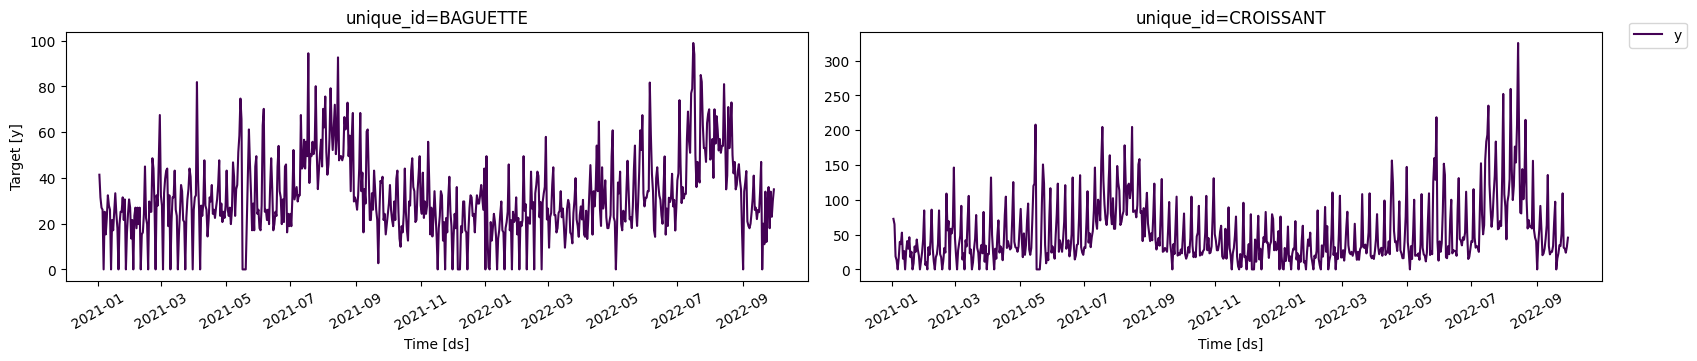

In [22]:
plot_series(df=df,ids=["BAGUETTE","CROISSANT"],palette="viridis")

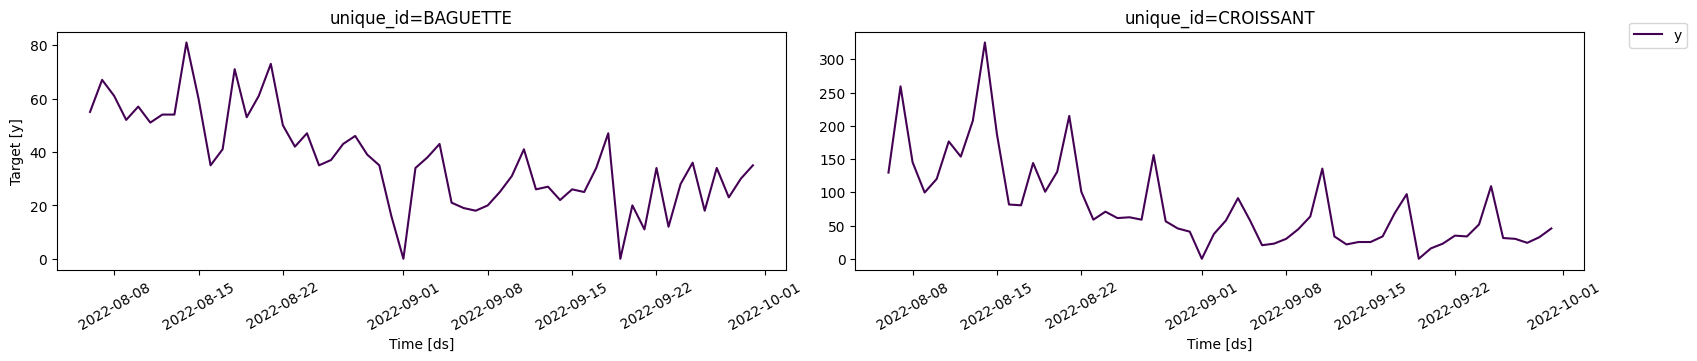

In [23]:
plot_series(df=df, ids=["BAGUETTE","CROISSANT"],max_insample_length=56, palette="viridis")

In [25]:
from statsforecast import StatsForecast
from statsforecast.models import Naive,HistoricAverage,WindowAverage,SeasonalNaive

In [26]:
horizon = 7

models = [Naive(),HistoricAverage(),WindowAverage(window_size=7),SeasonalNaive(season_length=7)]

sf = StatsForecast(models=models,freq="D",n_jobs=-1)
sf.fit(df=df)
preds = sf.predict(h=horizon)

In [28]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


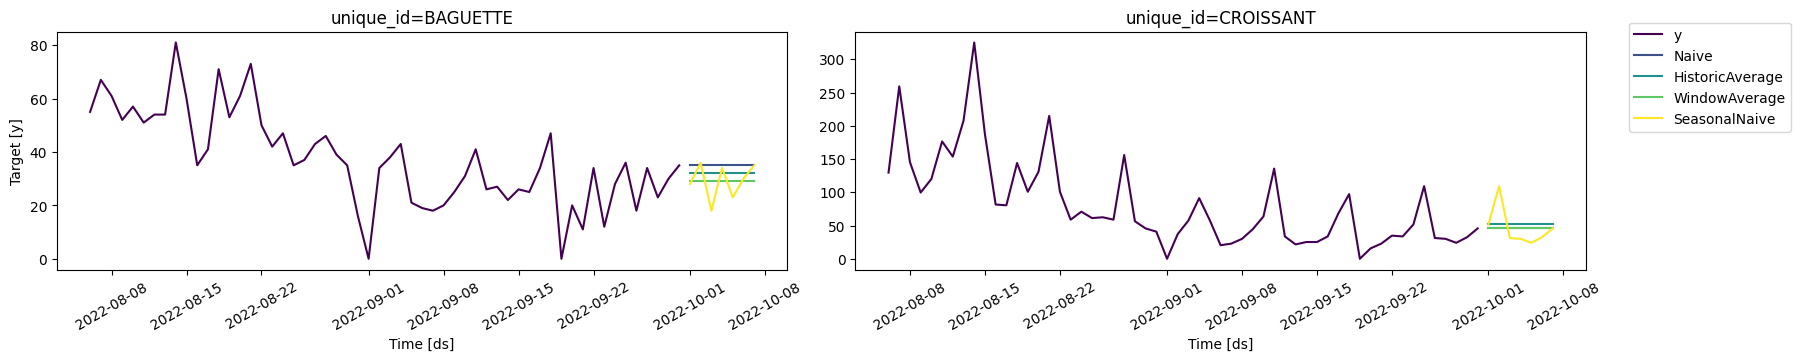

In [29]:
plot_series(df=df, forecasts_df=preds,ids=["BAGUETTE","CROISSANT"],max_insample_length=56, palette="viridis")

In [30]:
test = df.groupby("unique_id").tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [31]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test,preds,'left',['ds','unique_id'])

In [33]:
evaluation = evaluate(eval_df,metrics=[mae],)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [34]:
evaluation = evaluation.drop("unique_id",axis=1).groupby("metric").mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


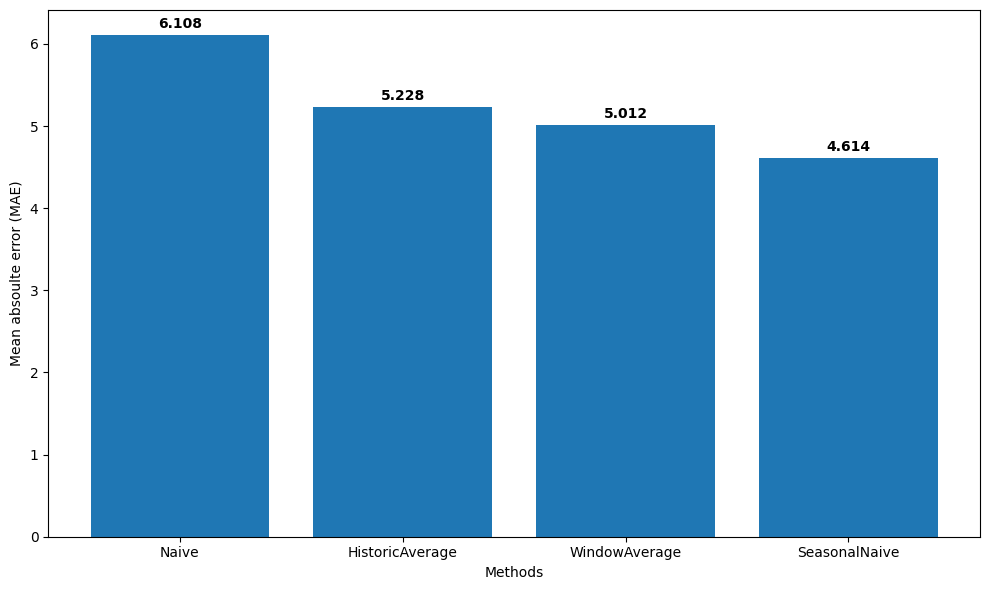

In [38]:
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0,1:].tolist()

plt.figure(figsize=(10,6))
bars = plt.bar(methods,values)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+ 0.05, f'{value:.3f}', ha='center', va='bottom',fontweight ="bold")
plt.xlabel("Methods")
plt.ylabel("Mean absoulte error (MAE)")
plt.tight_layout()

plt.show()